# 네이버 영화리뷰 감성분석

## 1) 데이터 준비와 확인

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Mecab
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import os
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [2]:
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

## 2) 데이터로더 구성

In [4]:
def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_train.append(temp_X)
        
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [5]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [6]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [7]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])

def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3) 모델구성을 위한 데이터 분석 및 가공

* 데이터셋 내 문장 길이 분포

In [8]:
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 :', np.mean(num_tokens))
print('문장길이 최대 :', np.max(num_tokens))
print('문장길이 표준편차 :', np.std(num_tokens))

문장길이 평균 : 15.971024731364448
문장길이 최대 : 116
문장길이 표준편차 : 12.84408055468762


* 적절한 최대 문장 길이 지정

In [9]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(round(np.sum(num_tokens < max_tokens) / len(num_tokens)*100, 2) ))

pad_sequences maxlen :  41
전체 문장의 93.43%가 maxlen 설정값 이내에 포함됩니다. 


* keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [10]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

In [11]:
# 패딩 추가 후 문장길이 리스트 재정의

total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  41.0
문장길이 최대 :  41
문장길이 표준편차 :  0.0


## 4) 모델구성 및 validation set 구성

In [12]:
x_val = X_train[:30000]   
y_val = y_train[:30000]

partial_x_train = X_train[30000:]  
partial_y_train = y_train[30000:]

## 5) 모델별훈련

* # LSTM

#### 1) 모델 훈련

In [13]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [14]:
vocab_size = 10000
word_vector_dim = 16

lstm_model = Sequential()
lstm_model.add(Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                20736     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 180,801
Trainable params: 180,801
Non-trainable params: 0
_________________________________________________________________


In [15]:
# 과적합 시 학습 조기종료, 검증데이터의 정확도가 이전보다 좋아질 경우만 모델 저장
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

lstm_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['acc'])

lstm_history = lstm_model.fit(partial_x_train,
                              partial_y_train,
                              epochs=10,
                              batch_size=32,
                              callbacks=[es, mc],
                              validation_data=(x_val, y_val),
                              verbose=1)

Epoch 1/10
3630/3631 [============================>.] - ETA: 0s - loss: 0.3873 - acc: 0.8246
Epoch 00001: val_acc improved from -inf to 0.85347, saving model to best_model.h5
3631/3631 [==============================] - 45s 12ms/step - loss: 0.3873 - acc: 0.8246 - val_loss: 0.3331 - val_acc: 0.8535
Epoch 2/10
3628/3631 [============================>.] - ETA: 0s - loss: 0.3063 - acc: 0.8687
Epoch 00002: val_acc improved from 0.85347 to 0.85837, saving model to best_model.h5
3631/3631 [==============================] - 45s 12ms/step - loss: 0.3064 - acc: 0.8686 - val_loss: 0.3220 - val_acc: 0.8584
Epoch 3/10
3627/3631 [============================>.] - ETA: 0s - loss: 0.2706 - acc: 0.8866
Epoch 00003: val_acc improved from 0.85837 to 0.85977, saving model to best_model.h5
3631/3631 [==============================] - 44s 12ms/step - loss: 0.2707 - acc: 0.8865 - val_loss: 0.3369 - val_acc: 0.8598
Epoch 4/10
3629/3631 [============================>.] - ETA: 0s - loss: 0.2440 - acc: 0.8985
E

In [16]:
loaded_model = load_model('best_model.h5')
lstm_results = loaded_model.evaluate(X_test,  y_test, verbose=2)

print(lstm_results)

1537/1537 - 5s - loss: 0.3364 - acc: 0.8590
[0.3363531529903412, 0.8590231537818909]


#### 2) 그래프 시각화

In [17]:
lstm_history_dict = lstm_history.history

acc = lstm_history_dict['acc']
val_acc = lstm_history_dict['val_acc']
loss = lstm_history_dict['loss']
val_loss = lstm_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

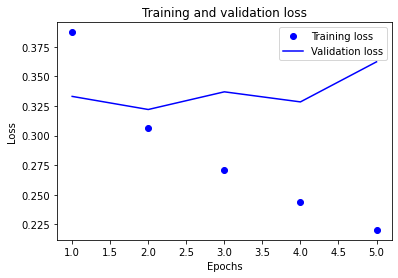

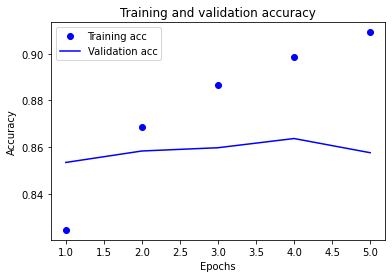

In [18]:
# Loss 그래프
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy 그래프
plt.clf()
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### 3) 학습된 Embedding 레이어 분석

In [19]:
embedding_layer = lstm_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 16)


In [20]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/LSTM.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = lstm_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [21]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['컴퓨터']
vector

array([-0.23161224, -0.05512281, -0.09890804, -0.03413069, -0.00862995,
        0.33455473,  0.05873756,  0.12833948,  0.05893002,  0.05989461,
       -0.0438175 ,  0.35313392,  0.20010957, -0.05696595, -0.00995595,
       -0.04183078], dtype=float32)

In [22]:
word_vectors.similar_by_word("추천")

[('최고봉', 0.9779566526412964),
 ('젊', 0.9775917530059814),
 ('수준급', 0.9774724245071411),
 ('즐겼', 0.9769138693809509),
 ('그해', 0.9752836227416992),
 ('색다른', 0.9751410484313965),
 ('킨', 0.9747977256774902),
 ('느껴집니다', 0.9744848012924194),
 ('어깨', 0.9737206697463989),
 ('위력', 0.9713107347488403)]

높은 정확도로 비슷한 단어를 추천함을 알 수 있다.

---

* # Conv1D

#### 1) 모델 훈련

In [23]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D

In [24]:
vocab_size = 10000
word_vector_dim = 16

conv_model = Sequential()
conv_model.add(Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
conv_model.add(Conv1D(16, 7, activation='relu'))
conv_model.add(MaxPooling1D(5))
conv_model.add(Conv1D(16, 7, activation='relu'))
conv_model.add(GlobalMaxPooling1D())
conv_model.add(Dense(8, activation='relu'))
conv_model.add(Dense(1, activation='sigmoid'))

conv_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [25]:
conv_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

conv_history = conv_model.fit(partial_x_train,
                         partial_y_train,
                         epochs=10,
                         batch_size=32,
                         validation_data=(x_val, y_val),
                         verbose=1)

Epoch 1/10
3631/3631 [==============================] - 7s 2ms/step - loss: 0.3857 - accuracy: 0.8219 - val_loss: 0.3331 - val_accuracy: 0.8536
Epoch 2/10
3631/3631 [==============================] - 7s 2ms/step - loss: 0.2891 - accuracy: 0.8791 - val_loss: 0.3252 - val_accuracy: 0.8575
Epoch 3/10
3631/3631 [==============================] - 7s 2ms/step - loss: 0.2340 - accuracy: 0.9058 - val_loss: 0.3429 - val_accuracy: 0.8564
Epoch 4/10
3631/3631 [==============================] - 7s 2ms/step - loss: 0.1844 - accuracy: 0.9292 - val_loss: 0.3889 - val_accuracy: 0.8513
Epoch 5/10
3631/3631 [==============================] - 7s 2ms/step - loss: 0.1467 - accuracy: 0.9460 - val_loss: 0.4433 - val_accuracy: 0.8462
Epoch 6/10
3631/3631 [==============================] - 7s 2ms/step - loss: 0.1195 - accuracy: 0.9572 - val_loss: 0.4875 - val_accuracy: 0.8452
Epoch 7/10
3631/3631 [==============================] - 7s 2ms/step - loss: 0.1017 - accuracy: 0.9637 - val_loss: 0.5669 - val_accuracy:

In [26]:
conv_results = conv_model.evaluate(X_test,  y_test, verbose=2)

print(conv_results)

1537/1537 - 1s - loss: 0.7342 - accuracy: 0.8261
[0.7342488169670105, 0.8261285424232483]


#### 2) 그래프 시각화

In [27]:
conv_history_dict = conv_history.history

acc = conv_history_dict['accuracy']
val_acc = conv_history_dict['val_accuracy']
loss = conv_history_dict['loss']
val_loss = conv_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

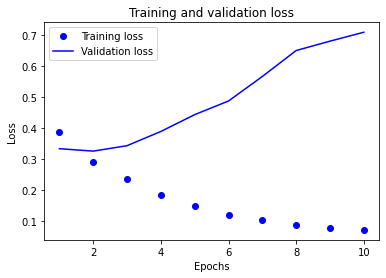

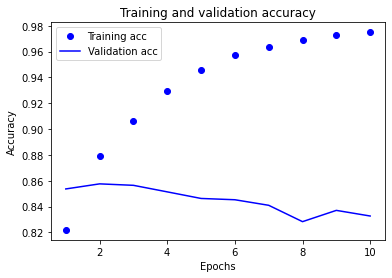

In [28]:
# Loss 그래프
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy 그래프
plt.clf() 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### 3) 학습된 Embedding 레이어 분석

In [29]:
embedding_layer = conv_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 16)


In [30]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/Conv.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = conv_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [31]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['컴퓨터']
vector

array([-0.01586851, -0.08497608, -0.10031389,  0.11009786,  0.08773369,
        0.24770074,  0.29154563, -0.38484982, -0.05678456,  0.12676686,
        0.22865036,  0.23125137, -0.00514019, -0.0250407 , -0.11347689,
       -0.05161467], dtype=float32)

In [32]:
word_vectors.similar_by_word("추천")

[('원조', 0.8452690839767456),
 ('굿', 0.8258330821990967),
 ('진하', 0.8202427625656128),
 ('great', 0.8189280033111572),
 ('신', 0.8134980201721191),
 ('기다려', 0.8122517466545105),
 ('♥', 0.8096330165863037),
 ('설레', 0.805724024772644),
 ('한정', 0.7983520030975342),
 ('ㅠㅠㅠㅠ', 0.7974637150764465)]

다소 낮은 정확도를 가지고 있음을 알 수 있다.

---

* # GlobalMaxPooling1D

#### 1) 모델 훈련

In [33]:
vocab_size = 10000
word_vector_dim = 16

gmp_model = Sequential()
gmp_model.add(Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
gmp_model.add(GlobalMaxPooling1D())
gmp_model.add(Dense(8, activation='relu'))
gmp_model.add(Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

gmp_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [34]:
gmp_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

gmp_history = gmp_model.fit(partial_x_train,
                            partial_y_train,
                            epochs=10,
                            batch_size=32,
                            validation_data=(x_val, y_val),
                            verbose=1)

Epoch 1/10
3631/3631 [==============================] - 4s 1ms/step - loss: 0.4142 - accuracy: 0.8132 - val_loss: 0.3550 - val_accuracy: 0.8426
Epoch 2/10
3631/3631 [==============================] - 5s 1ms/step - loss: 0.3231 - accuracy: 0.8620 - val_loss: 0.3491 - val_accuracy: 0.8482
Epoch 3/10
3631/3631 [==============================] - 4s 1ms/step - loss: 0.2923 - accuracy: 0.8776 - val_loss: 0.3528 - val_accuracy: 0.8481
Epoch 4/10
3631/3631 [==============================] - 4s 1ms/step - loss: 0.2705 - accuracy: 0.8886 - val_loss: 0.3606 - val_accuracy: 0.8466
Epoch 5/10
3631/3631 [==============================] - 5s 1ms/step - loss: 0.2537 - accuracy: 0.8974 - val_loss: 0.3696 - val_accuracy: 0.8458
Epoch 6/10
3631/3631 [==============================] - 5s 1ms/step - loss: 0.2404 - accuracy: 0.9032 - val_loss: 0.3815 - val_accuracy: 0.8433
Epoch 7/10
3631/3631 [==============================] - 5s 1ms/step - loss: 0.2289 - accuracy: 0.9092 - val_loss: 0.3909 - val_accuracy:

In [35]:
gmp_results = gmp_model.evaluate(X_test,  y_test, verbose=2)

print(gmp_results)

1537/1537 - 1s - loss: 0.4354 - accuracy: 0.8326
[0.43538692593574524, 0.8325772285461426]


In [36]:
gmp_history_dict = gmp_history.history

acc = gmp_history_dict['accuracy']
val_acc = gmp_history_dict['val_accuracy']
loss = gmp_history_dict['loss']
val_loss = gmp_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

#### 2) 그래프 시각화

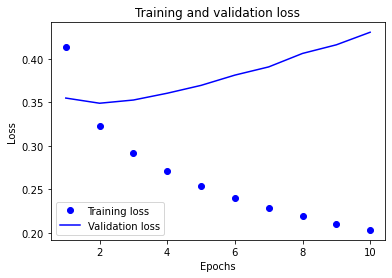

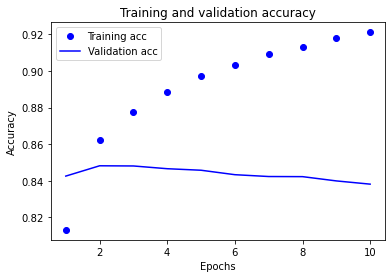

In [37]:
# Loss 그래프
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy 그래프
plt.clf()
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### 3) 학습된 Embedding 레이어 분석

In [38]:
embedding_layer = gmp_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 16)


In [39]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/GlobalMaxPooling.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = gmp_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [40]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['컴퓨터']
vector

array([-0.6369704 , -0.02622382, -0.05904836, -0.22717537, -0.20987444,
       -0.24942498, -0.04377233, -0.46514106, -0.1083621 , -0.36539295,
       -0.01360741, -0.2911179 , -0.03481179, -0.106375  , -0.14020546,
       -0.1938369 ], dtype=float32)

In [41]:
word_vectors.similar_by_word("추천")

[('핀', 0.9010083675384521),
 ('바탕', 0.8943302631378174),
 ('짙', 0.8756757378578186),
 ('세세', 0.8749301433563232),
 ('리즈', 0.8718863725662231),
 ('예쁜', 0.8704178333282471),
 ('이란', 0.8680400848388672),
 ('우리', 0.8603310585021973),
 ('죠', 0.8579314351081848),
 ('본지', 0.8576925992965698)]

---

In [42]:
print('LSTM 모델의 정확도 :', round(lstm_results[1]*100, 2))
print('Conv1D 모델의 정확도 :', round(conv_results[1]*100, 2))
print('GlobalMaxPooling1D 모델의 정확도 :', round(gmp_results[1]*100, 2))

LSTM 모델의 정확도 : 85.9
Conv1D 모델의 정확도 : 82.61
GlobalMaxPooling1D 모델의 정확도 : 83.26


---

## 6) 한국어 Word2Vec 임베딩 활용

In [47]:
# 사전학습된 임베딩 레이어 분석
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
w2v_model = Word2Vec.load(word2vec_path)
print(w2v_model.wv.vectors.shape)
w2v_model.wv.most_similar("추천")

(30185, 200)


[('위촉', 0.6401861310005188),
 ('천거', 0.6389721632003784),
 ('추대', 0.5849215388298035),
 ('선출', 0.5803494453430176),
 ('초청', 0.5759262442588806),
 ('발탁', 0.5613523721694946),
 ('선정', 0.5511638522148132),
 ('임명', 0.5414161682128906),
 ('초빙', 0.5363222360610962),
 ('기용', 0.5326868295669556)]

사전학습된 임베딩 레이어가 자체학습 임베딩 레이어보다 성능이 안 좋음

#### 1) 임베딩 matrix 생성

In [48]:
vocab_size = 10000
word_vector_dim = 200

embedding_matrix = np.zeros((vocab_size, word_vector_dim))

for i in range(4, vocab_size):
    if index_to_word[i] in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[index_to_word[i]]

#### 2) 모델 훈련

In [57]:
# 성능을 높이기 위해 LSTM 모델 선택하고 dropout 옵션 추가

from tensorflow.keras.layers import Flatten

vocab_size = 10000
word_vector_dim = 200

w2v_model = Sequential()
w2v_model.add(Embedding(vocab_size,
                        word_vector_dim,
                        weights = [embedding_matrix],
                        input_length=maxlen,
                        trainable=True))

w2v_model.add(LSTM(64, dropout=0.2))
w2v_model.add(Flatten())
w2v_model.add(Dense(1, activation='sigmoid'))

w2v_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                67840     
_________________________________________________________________
flatten_6 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 2,067,905
Trainable params: 2,067,905
Non-trainable params: 0
_________________________________________________________________


In [58]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

w2v_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['acc'])

w2v_history = w2v_model.fit(partial_x_train,
                            partial_y_train,
                            epochs=10,
                            batch_size=32,
                            callbacks=[es, mc],
                            validation_data=(x_val, y_val),
                            verbose=1)

Epoch 1/10
3631/3631 [==============================] - ETA: 0s - loss: 0.3957 - acc: 0.8181
Epoch 00001: val_acc improved from -inf to 0.85837, saving model to best_model.h5
3631/3631 [==============================] - 107s 29ms/step - loss: 0.3957 - acc: 0.8181 - val_loss: 0.3265 - val_acc: 0.8584
Epoch 2/10
3631/3631 [==============================] - ETA: 0s - loss: 0.3057 - acc: 0.8692
Epoch 00002: val_acc improved from 0.85837 to 0.86423, saving model to best_model.h5
3631/3631 [==============================] - 106s 29ms/step - loss: 0.3057 - acc: 0.8692 - val_loss: 0.3192 - val_acc: 0.8642
Epoch 3/10
3631/3631 [==============================] - ETA: 0s - loss: 0.2711 - acc: 0.8858
Epoch 00003: val_acc improved from 0.86423 to 0.86853, saving model to best_model.h5
3631/3631 [==============================] - 105s 29ms/step - loss: 0.2711 - acc: 0.8858 - val_loss: 0.3124 - val_acc: 0.8685
Epoch 4/10
3631/3631 [==============================] - ETA: 0s - loss: 0.2430 - acc: 0.899

In [59]:
loaded_model = load_model('best_model.h5')
w2v_results = loaded_model.evaluate(X_test,  y_test, verbose=2)

print(w2v_results)

1537/1537 - 6s - loss: 0.3274 - acc: 0.8636
[0.32742738723754883, 0.8636409640312195]


In [60]:
print('LSTM 모델의 정확도 :', round(lstm_results[1]*100, 2))
print('Word2Vec 모델의 정확도 :', round(w2v_results[1]*100, 2))

LSTM 모델의 정확도 : 85.9
Word2Vec 모델의 정확도 : 86.36


---

세 모델 중 LSTM 모델이 가장 높은 정확도를 가지고 있음을 알 수 있다.   
Word2Vec 임베딩에 LSTM 모델을 합쳐 훈련시켰을 때 조금 더 좋은 성능을 보인다.